# Lecture 3 - Churn Prediction

### Notebook by: Christian Vincent D. Cabral

For this lecture, we're going to deal with Classification(binary). We would like to predict whether or not a customer will churn(leave the company for another company of the same service.\
The data of the customers are treated as the features ***X*** and their status(churn/not churn) is the target ***y***.

```
The idea is to predict the likelihood of a customer churning.

```

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Lecture 3.2 - Data Preparation

In [2]:
df = pd.read_csv('../../Datasets/telco/telco.csv');
df.columns = df.columns.str.lower()
df.head().T

,0,1,2,3,4
customerid,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
seniorcitizen,0,0,0,0,0
partner,Yes,No,No,No,No
dependents,No,No,No,No,No
tenure,1,34,2,45,2
phoneservice,No,Yes,Yes,No,Yes
multiplelines,No phone service,No,No,No phone service,No
internetservice,DSL,DSL,DSL,DSL,Fiber optic
onlinesecurity,No,Yes,Yes,Yes,No


In [36]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int32
dtype: object

In [4]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,no
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.5,no
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,yes
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,no
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,yes


In [5]:
# convert to numeric because totalcharges is of type object
# ignore errors with errors='coerce'
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
# fill NaN with zeros
df.totalcharges = df.totalcharges.fillna(0)

In [6]:
# convert target to zeros and ones
df['churn'] = (df['churn'] == 'yes').astype(int)

In [7]:
df['churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int32

# Lecture 3.3 - Validation Framework

In [8]:
# model
from sklearn.linear_model import LogisticRegression

# for calculating the accuracy
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# for splitting the data
from sklearn.model_selection import train_test_split

In [9]:
# 60, 20, 20 splitting
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
len(df_full_train), len(df_test)

(5634, 1409)

In [10]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_val), len(df_test), len(df_train)

(1409, 1409, 4225)

In [11]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
full_train_y = df_full_train.churn.values
train_y = df_train.churn.values
val_y = df_val.churn.values
test_y = df_test.churn.values

In [13]:
len(val_y)

1409

In [14]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

# Lecture 3.4 - Exploratory Data Analysis

In [15]:
df_full_train.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0


In [16]:
# percentage of churn values
df_full_train.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [17]:
# get churn rate by getting the number of 1s / size 
global_churn_rate = df_full_train.churn.mean()
global_churn_rate.round(2) # must be equal to normalized value of 1

0.27

In [18]:
numerical_variables = ['tenure', 'monthlycharges', 'totalcharges']
categorical_variables =[column for column in df_full_train.columns if column not in numerical_variables and column != 'churn' and column != 'customerid']

In [19]:
df[categorical_variables].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

# Lecture 3.5 - Feature Importance: Churn Rate and Risk Ratio

### Churn Rate

In [20]:
df['gender'].unique()

array(['female', 'male'], dtype=object)

In [21]:
churn_rates = {}
for column in df_full_train[categorical_variables]:
    churn_rates[column] = []
    for v in df_full_train[column].unique():
        churn_rate = df_full_train[df_full_train[column] == v].churn.mean()
        churn_rates[column].append((v, churn_rate - global_churn_rate))

In [22]:
for k, v in churn_rates.items():
    print("Category: ", k)
    print("Churn Rates: ", v)
    print()

Category:  gender
Churn Rates:  [('male', -0.006754520462819769), ('female', 0.006855983216553063)]

Category:  seniorcitizen
Churn Rates:  [(0, -0.02769782663705883), (1, 0.14340914186424525)]

Category:  partner
Churn Rates:  [('yes', -0.06493474245795922), ('no', 0.05984095297455855)]

Category:  dependents
Churn Rates:  [('yes', -0.10430178461160824), ('no', 0.04379202952695044)]

Category:  phoneservice
Churn Rates:  [('yes', 0.0030808971813763297), ('no', -0.028651780551483264)]

Category:  multiplelines
Churn Rates:  [('no', -0.012560643710803454), ('yes', 0.020773465429757276), ('no_phone_service', -0.028651780551483264)]

Category:  internetservice
Churn Rates:  [('no', -0.19216297331313306), ('dsl', -0.07762058472731118), ('fiber_optic', 0.15520338897860236)]

Category:  onlinesecurity
Churn Rates:  [('no_internet_service', -0.19216297331313306), ('yes', -0.11674224466659797), ('no', 0.15095304848907226)]

Category:  onlinebackup
Churn Rates:  [('no_internet_service', -0.1921

**> 0 churn rates mean it is more likely for them to churn.**

### Risk Ratio

In [23]:
churn_rates = {}
for column in df_full_train[categorical_variables]:
    churn_rates[column] = []
    for v in df_full_train[column].unique():
        churn_rate = df_full_train[df_full_train[column] == v].churn.mean()
        churn_rates[column].append((v, churn_rate / global_churn_rate))

In [24]:
for k, v in churn_rates.items():
    print("Category: ", k)
    print("Churn Rates: ", v)
    print()

Category:  gender
Churn Rates:  [('male', 0.9749802969838747), ('female', 1.0253955354648652)]

Category:  seniorcitizen
Churn Rates:  [(0, 0.8974033167171667), (1, 1.5312078272604588)]

Category:  partner
Churn Rates:  [('yes', 0.7594724924338315), ('no', 1.2216593879412643)]

Category:  dependents
Churn Rates:  [('yes', 0.6136513777108475), ('no', 1.162211896354266)]

Category:  phoneservice
Churn Rates:  [('yes', 1.011412080683678), ('no', 0.8938697359453933)]

Category:  multiplelines
Churn Rates:  [('no', 0.9534735919351304), ('yes', 1.0769478660297518), ('no_phone_service', 0.8938697359453933)]

Category:  internetservice
Churn Rates:  [('no', 0.28820105743182667), ('dsl', 0.7124823311284213), ('fiber_optic', 1.5748953934947045)]

Category:  onlinesecurity
Churn Rates:  [('no_internet_service', 0.28820105743182667), ('yes', 0.5675701469746135), ('no', 1.5591515287228357)]

Category:  onlinebackup
Churn Rates:  [('no_internet_service', 0.28820105743182667), ('yes', 0.8046595701948

**\> 1.0 values mean they are more likely to churn.**

In [25]:
from IPython.display import display

In [26]:
for column in categorical_variables:
    print(f"Processing column: {column}")
    df_group = df_full_train.groupby(column).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn_rate
    df_group['risk'] = df_group['mean'] / global_churn_rate
    display(df_group)
    print('\n\n')

Processing column: gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980





Processing column: seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208





Processing column: partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472





Processing column: dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651





Processing column: phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412





Processing column: multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948





Processing column: internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201





Processing column: onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570





Processing column: onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660





Processing column: deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480





Processing column: techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390





Processing column: streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328





Processing column: streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182





Processing column: contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730





Processing column: paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560





Processing column: paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


# Lecture 3.6 - Feature Importance: Mutual Information

Mutual Information is how one variable affects the outcome or the value of another.

In [27]:
# import mutual_info_score from sklearn.metrics
from sklearn.metrics import mutual_info_score

In [28]:
# we are interested in our target variable (churn)
mutual_info_score(df_full_train.churn, df_full_train.contract)

0.0983203874041556

In [36]:
# apply mutual_info_score to the categorical variables
mutual_info = {}
for column in categorical_variables:
    mutual_info[column] = mutual_info_score(df_full_train.churn, df_full_train[column])
# sort in descending order by value
sorted(mutual_info.items(), key=lambda x : x[1], reverse=True)

[('contract', 0.0983203874041556),
 ('onlinesecurity', 0.06308524972985574),
 ('techsupport', 0.06103245991777444),
 ('internetservice', 0.055867945893496467),
 ('onlinebackup', 0.0469234640537918),
 ('deviceprotection', 0.04345286925268559),
 ('paymentmethod', 0.043210027531582915),
 ('streamingtv', 0.03185333110086085),
 ('streamingmovies', 0.03158089669519908),
 ('paperlessbilling', 0.01758882715925275),
 ('dependents', 0.012345815445534689),
 ('partner', 0.009967689095399745),
 ('seniorcitizen', 0.009410216144208144),
 ('multiplelines', 0.0008574478744731856),
 ('phoneservice', 0.00022871269738296285),
 ('gender', 0.0001174846211139946)]

or we can do it this way:

In [41]:
def mutual_info_churn_score(series):
    return mutual_info_score(df_full_train.churn, series)

mi = df_full_train[categorical_variables].apply(mutual_info_churn_score).sort_values(ascending=False)
mi

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

# Lecture 3.7 - Feature Importance: Correlation

Correlation is a way to measure the feature importance of numerical variables.

In [49]:
df_full_train[numerical_variables].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

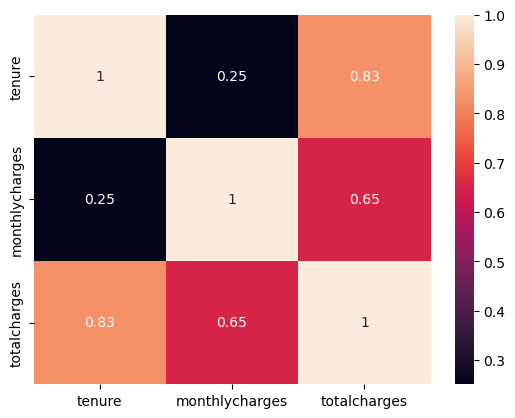

In [47]:
corr_matrix = df_full_train[numerical_variables].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

**Low**, **Moderate**, and **Strong** correlation:
```
Low:
    0.0 - 0.2
    -0.2 - 0.0
Moderate:
    0.2 - 0.5
    -0.5 - -0.2
High:
    0.6 - 1.0
    -1.0 - -0.6
```

A good candidate to drop is *totalcharges* because it is highly correlated to *tenure* and moderately correlated to *monthlycharges*

In [53]:
df_full_train[df_full_train.tenure <= 2].churn.mean()

0.5953420669577875

In [57]:
df_full_train[(df_full_train.tenure > 2) & (df_full_train.tenure <= 12)].churn.mean()

0.3994413407821229

In [58]:
df_full_train[df_full_train.tenure > 12].churn.mean()

0.17634908339788277

According to the churn rates in the data above, the longer the customer stays, the less likely they will churn.

# Lecture 3.8 - One-hot Encoding

**One-hot encoding** is what we call the technique we used in the previous lecture to convert a categorical variable into multiple columns with values *0 or 1*

In [70]:
# one hot encoding from sklearn
from sklearn.feature_extraction import DictVectorizer

In [102]:
train_dicts = df_train[categorical_variables + numerical_variables].to_dict(orient='records')
train_dicts[0]

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'two_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 72,
 'monthlycharges': 115.5,
 'totalcharges': 8425.15}

In [103]:
dv = DictVectorizer(sparse=False)

In [104]:
# dv.fit_transform(X) fits and immediately transforms the DictVectorizer to a matrix of 0s and 1s
dv.fit(train_dicts)
# get column names
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

In [109]:
X_train = dv.transform(train_dicts)

In [113]:
X_train.shape

(4225, 45)

# Lecture 3.9 - Logistic Regression